# Schedulers en PyTorch

¡Bienvenido a esta exploración de los learning rate schedulers en PyTorch! Como has aprendido en las clases, gestionar los learning rates es vital para optimizar el entrenamiento de los modelos, y PyTorch proporciona varias herramientas para agilizar este proceso. Los learning rate schedulers son esenciales para ajustar dinámicamente los learning rates de acuerdo con la fase de entrenamiento, ayudando a facilitar una convergencia más rápida y mejorar la generalización.

En este notebook, te sumergirás en la mecánica de diferentes learning rate schedulers. Específicamente, tú:

* Explorarás cómo los schedulers como `StepLR`, `CosineAnnealingLR` y `ReduceLROnPlateau` ajustan el learning rate para mantener la eficiencia del entrenamiento.

* Usarás estos schedulers dentro de un training loop típico.

* Aprenderás a visualizar la dinámica del entrenamiento, demostrando el impacto de los schedulers en el rendimiento del modelo en comparación con un learning rate constante.

Al final de este notebook, tendrás experiencia práctica en la aplicación de learning rate schedulers, mejorando tu comprensión de su papel en el entrenamiento de modelos.

In [1]:
import sys
import time
import warnings

# Redirigir stderr a un agujero negro para capturar otros mensajes potenciales
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import helper_utils

helper_utils.set_seed(42)

In [3]:
# # Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CPU


## Una inmersión más profunda en el proceso de entrenamiento

En esta sección, realizarás un análisis más profundo de los experimentos que hemos hecho en el laboratorio anterior.
Utilizarás un modelo simple (`SimpleCNN`) y el dataset CIFAR-10, pero ahora inspeccionaremos el proceso de entrenamiento más de cerca graficando las curvas de **training loss** y **validation accuracy**.

Esto ayudará a comprender cómo el modelo aprende a lo largo del tiempo y cómo diferentes learning rates afectan la dinámica del entrenamiento.

En la siguiente celda encontramos la definición del modelo `SimpleCNN` y la función `evaluate_epoch` que puedes usar para evaluar el modelo en el conjunto de validación (validation set) *después de cada epoch*.
Se proporciona la función `train_and_evaluate` para entrenar el modelo por un número especificado de epochs y evaluarlo durante el entrenamiento.

Las funciones `get_data_loaders` y `train_epoch` se proporcionan desde el módulo `helper_utils`.
Se utilizan para cargar el dataset CIFAR-10 y entrenar el modelo por un epoch, respectivamente.

In [4]:
class SimpleCNN(nn.Module):
    """Una arquitectura simple de Red Neuronal Convolucional (CNN).

    Esta clase define una CNN de dos capas con max pooling, dropout y
    capas totalmente conectadas, adecuada para tareas básicas de clasificación de imágenes.
    """
    def __init__(self):
        """Inicializa las capas de la red neuronal."""
        # Inicializa la clase padre nn.Module
        super(SimpleCNN, self).__init__()
        # Primera capa convolucional (3 canales de entrada, 16 de salida, kernel de 3x3)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Segunda capa convolucional (16 canales de entrada, 32 de salida, kernel de 3x3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Capa de max pooling con una ventana de 2x2 y stride de 2
        self.pool = nn.MaxPool2d(2, 2)
        # Primera capa totalmente conectada (linear)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Segunda capa totalmente conectada (linear), que sirve como capa de salida
        self.fc2 = nn.Linear(64, 10)
        # Capa de dropout para regularización
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        """Define el forward pass de la red.

        Args:
            x (torch.Tensor): El tensor de entrada con forma (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Los logits de salida de la red.
        """
        # Aplica la primera convolución, activación ReLU y max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Aplica la segunda convolución, activación ReLU y max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Aplana (Flatten) los mapas de características para las capas totalmente conectadas
        x = x.view(-1, 32 * 8 * 8)
        # Aplica la primera capa totalmente conectada con activación ReLU
        x = F.relu(self.fc1(x))
        # Aplica dropout para regularización
        x = self.dropout(x)
        # Aplica la capa de salida final
        x = self.fc2(x)
        return x


def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128, p_bar=None):
    """Orquesta el entrenamiento y la evaluación de un modelo para una configuración dada.

    Esta función maneja el flujo de trabajo de extremo a extremo: establecer una semilla aleatoria,
    inicializar el modelo, el optimizer, la loss function y los dataloaders, y luego
    ejecutar el bucle de entrenamiento principal.

    Args:
        learning_rate (float): El learning rate para el optimizer.
        device: El dispositivo (ej., 'cuda' o 'cpu') para el entrenamiento y la evaluación.
        n_epochs (int, opcional): El número de epochs de entrenamiento. Por defecto es 25.
        batch_size (int, opcional): El batch size para los dataloaders. Por defecto es 128.
        p_bar (opcional): Un manejador de barra de progreso existente. Por defecto es None.

    Returns:
        dict: Un diccionario que contiene el historial de entrenamiento y validación
              (loss y accuracy).
    """
    # Establece la semilla aleatoria para reproducibilidad
    helper_utils.set_seed(42)

    # Inicializa el modelo y lo mueve al dispositivo especificado
    model = SimpleCNN().to(device)

    # Define el optimizer con el learning rate especificado
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define la función de pérdida (loss function)
    loss_fn = nn.CrossEntropyLoss()

    # Prepara los dataloaders de entrenamiento (train) y validación (val)
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Llama al bucle de entrenamiento principal para entrenar el modelo y obtener el historial (history)
    history = helper_utils.train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fcn=loss_fn,
        device=device,
        n_epochs=n_epochs,
        p_bar=p_bar
    )

    # Retorna el historial de entrenamiento recolectado
    return history

Ahora el modelo se entrena durante varios epochs para cada uno de los learning rates especificados.
Los resultados se almacenan en `training_curves`, y las curvas (train loss y validation accuracy) se grafican para cada learning rate.

In [5]:
# Different learning rates to be analyzed
learning_rates = [0.0002, 0.001, 0.005] # Small, medium, and large learning rates

training_curves = []
n_epochs = 25
batch_size = 128

p_bar = helper_utils.get_p_bar(n_epochs)

# Get the total number of learning rates to check against the index
num_learning_rates = len(learning_rates)

# Train and evaluate the model for each learning rate
for i, lr in enumerate(learning_rates):
    print(f"\nTraining with learning rate: {lr}\n")
    history = train_and_evaluate(learning_rate=lr, n_epochs=n_epochs, batch_size=batch_size, device=device, p_bar=p_bar)
    training_curves.append(history)
    # Only reset the progress bar if it's NOT the last iteration
    if i < num_learning_rates - 1:
        p_bar.reset()

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/10 [00:00<?, ?it/s]


Training with learning rate: 0.0002



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.7874, Training accuracy: 0.3584
At epoch 5: Validation loss: 1.6975, Validation accuracy: 0.4080


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.5831, Training accuracy: 0.4274
At epoch 10: Validation loss: 1.5367, Validation accuracy: 0.4595


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.4720, Training accuracy: 0.4652
At epoch 15: Validation loss: 1.4387, Validation accuracy: 0.4940


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.3934, Training accuracy: 0.4989
At epoch 20: Validation loss: 1.3850, Validation accuracy: 0.5060


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 1.3382, Training accuracy: 0.5144
At epoch 25: Validation loss: 1.3482, Validation accuracy: 0.5175
Training complete


Training with learning rate: 0.001



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.5185, Training accuracy: 0.4409
At epoch 5: Validation loss: 1.4724, Validation accuracy: 0.4805


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.3582, Training accuracy: 0.5006
At epoch 10: Validation loss: 1.3190, Validation accuracy: 0.5360


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.2236, Training accuracy: 0.5466
At epoch 15: Validation loss: 1.2605, Validation accuracy: 0.5610


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.0972, Training accuracy: 0.6042
At epoch 20: Validation loss: 1.2124, Validation accuracy: 0.5755


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.9840, Training accuracy: 0.6361
At epoch 25: Validation loss: 1.2056, Validation accuracy: 0.5850
Training complete


Training with learning rate: 0.005



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4106, Training accuracy: 0.4736
At epoch 5: Validation loss: 1.3579, Validation accuracy: 0.5065


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1504, Training accuracy: 0.5730
At epoch 10: Validation loss: 1.2516, Validation accuracy: 0.5495


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.9456, Training accuracy: 0.6405
At epoch 15: Validation loss: 1.2655, Validation accuracy: 0.5710


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.8032, Training accuracy: 0.6969
At epoch 20: Validation loss: 1.3690, Validation accuracy: 0.5780


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.6972, Training accuracy: 0.7256
At epoch 25: Validation loss: 1.5404, Validation accuracy: 0.5645
Training complete



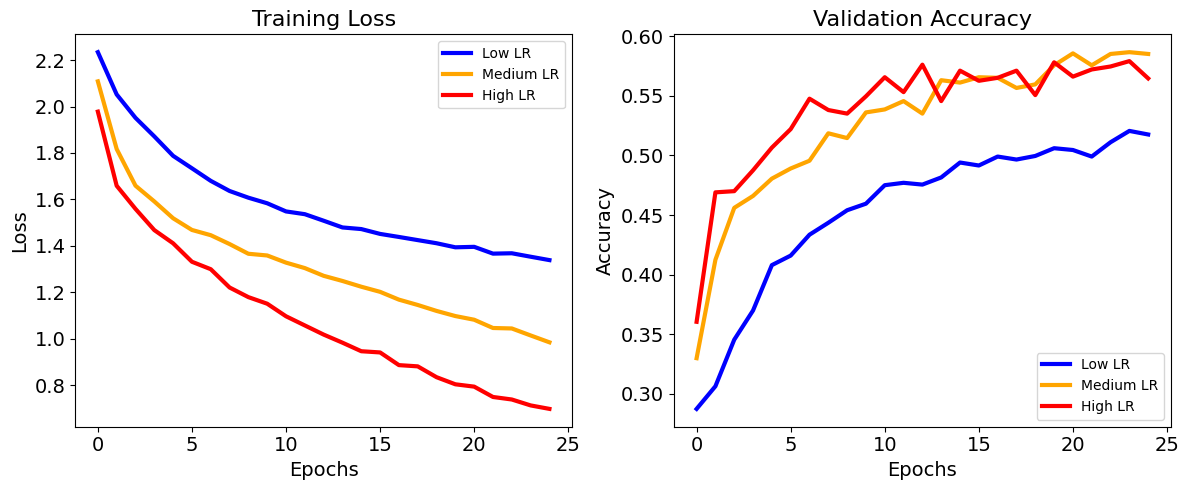

In [6]:
colors = ['blue', 'orange', 'red']
labels = ['Low LR', 'Medium LR', 'High LR']

helper_utils.plot_learning_curves(colors, labels, training_curves)

# Each color corresponds to a different learning rate: blue for low, orange for medium, and red for high.

### Análisis del Learning Rate

Cada color representa un learning rate diferente: azul para bajo (low), naranja para medio (medium) y rojo para alto (high).

- **Learning Rate Bajo:**
El accuracy de validación mejora gradualmente y puede requerir una cantidad significativa de tiempo (muchas épocas) para alcanzar su punto máximo.

- **Learning Rate Medio:**
El accuracy de validación aumenta rápidamente y, al final de las 25 épocas, está superando a los otros dos modelos.

- **Learning Rate Alto:**
Inicialmente, el accuracy de validación es el más alto durante las primeras épocas, pero eventualmente se estanca, lo que indica inestabilidad donde el modelo lucha por mejorar con un learning rate tan alto.

Entre estas opciones, el learning rate medio logra el mejor equilibrio entre la velocidad de aprendizaje y la generalización. ¿Podrías lograr un mejor modelo combinando estos learning rates—comenzando con una tasa alta durante las primeras épocas, luego pasando a una media y finalmente a una baja?

## Schedulers
En la sección anterior, exploraste cómo la elección del learning rate impacta el rendimiento del modelo. Un learning rate alto puede generar inestabilidad, mientras que uno bajo podría ralentizar el entrenamiento o producir resultados subóptimos. Los learning rate schedulers ofrecen una solución al ajustar automáticamente el learning rate a lo largo del entrenamiento, estableciéndolo inicialmente alto para un aprendizaje rápido y luego reduciéndolo para mejorar la convergencia y la generalización.


En esta práctica, investigarás tres schedulers diferentes. Comencemos con el scheduler `StepLR`, que reduce el learning rate por un factor especificado a intervalos regulares; específicamente, después de un número determinado de épocas. Repetirás el proceso de entrenamiento anterior, pero esta vez emplearás un scheduler que disminuye el learning rate por un factor de 0.2 cada 10 épocas.

In [8]:
helper_utils.set_seed(42)

# Initialize the model, optimizer, loss function, and dataloaders
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005) # iniciar con un alto learning rate

Los schedulers están integrados en el módulo `torch.optim.lr_scheduler` de PyTorch y pueden integrarse fácilmente en tu training loop.
Normalmente, inicializas un scheduler con el optimizer y los parámetros que definen cómo cambia el learning rate a lo largo del tiempo.

El scheduler `StepLR`, por ejemplo:
  - Toma el optimizer como entrada.
  - Requiere un `step_size`, que es el número de epochs antes de reducir el learning rate.
  - Utiliza un factor `gamma`, que es el factor por el cual se reduce el learning rate.

In [9]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2) # reducir la tasa de aprendizaje en un 20% respecto a su valor anterior

El proceso de entrenamiento es similar al anterior, pero el learning rate es ajustado por el scheduler después de cada epoch utilizando el método `scheduler.step()`.
Se puede acceder al learning rate actual utilizando `scheduler.get_last_lr()`.

El modelo se entrena durante varios epochs con el scheduler `StepLR`, y las curvas de entrenamiento se grafican para comparar los resultados con los experimentos anteriores para el learning rate medio.

In [10]:
loss_fn = nn.CrossEntropyLoss()

train_loader, val_loader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

history_LR = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": [],
}


pbar = helper_utils.NestedProgressBar(
    total_epochs=n_epochs,
    total_batches=len(train_loader),
    epoch_message_freq=5,
    mode="train",
)

for epoch in range(n_epochs):
    pbar.update_epoch(epoch+1)

    # Entrenar el modelo por un epoch
    train_loss, train_acc = helper_utils.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)

    # Evaluar el modelo en el conjunto de validación (validation set)
    val_loss, val_acc = helper_utils.evaluate_epoch(model, val_loader, loss_fn, device)

    # Obtener el learning rate actual ANTES de avanzar el scheduler.
    # Esto captura el LR que se acaba de usar para el epoch de entrenamiento anterior.
    current_lr = scheduler.get_last_lr()[0]
    
    # Avanzar el scheduler (actualiza el LR para el PRÓXIMO epoch)
    scheduler.step()
    
    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

    history_LR["train_loss"].append(train_loss)
    history_LR["train_acc"].append(train_acc)
    history_LR["val_loss"].append(val_loss)
    history_LR["val_acc"].append(val_acc)
    history_LR["lr"].append(current_lr)

pbar.close('Training complete with StepLR scheduler')

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4106, Training accuracy: 0.4736, LR: 0.005000
At epoch 5: Validation loss: 1.3579, Validation accuracy: 0.5065


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1504, Training accuracy: 0.5730, LR: 0.005000
At epoch 10: Validation loss: 1.2516, Validation accuracy: 0.5495


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.9133, Training accuracy: 0.6583, LR: 0.001000
At epoch 15: Validation loss: 1.2017, Validation accuracy: 0.5845


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.8286, Training accuracy: 0.6836, LR: 0.001000
At epoch 20: Validation loss: 1.2149, Validation accuracy: 0.5830


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.7715, Training accuracy: 0.7109, LR: 0.000200
At epoch 25: Validation loss: 1.2364, Validation accuracy: 0.5840
Training complete with StepLR scheduler


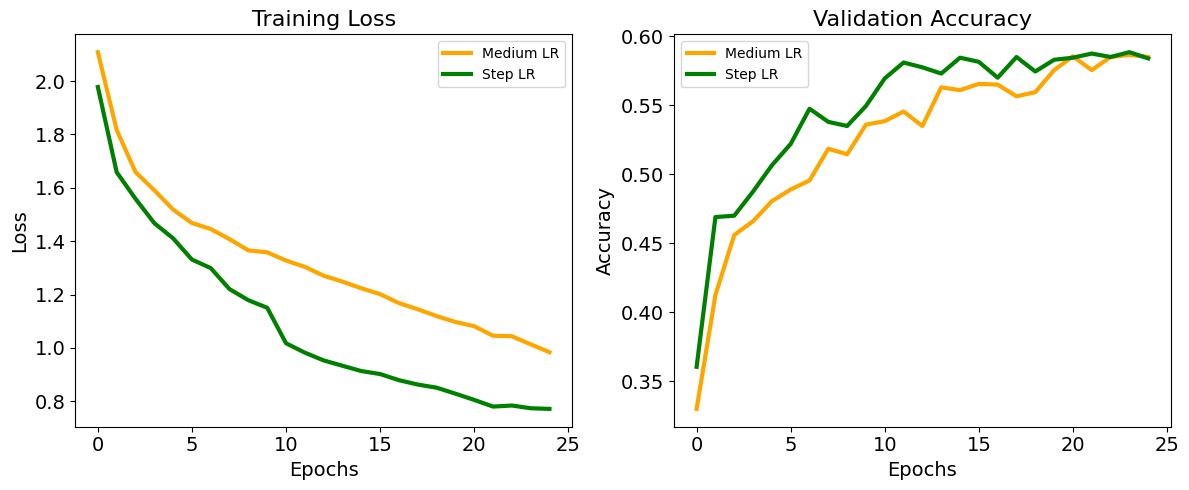

In [11]:
idx = 1
history_constant = training_curves[idx]

colors = ['orange', 'green']
labels = ['Medium LR', 'Step LR']
histories = [history_constant, history_LR]

helper_utils.plot_learning_curves(colors, labels, histories)

### Análisis de Medium LR y StepLR Scheduler

Los gráficos muestran una comparación entre el entrenamiento con un learning rate constante (naranja) y el uso de un scheduler `StepLR` (verde). Con StepLR, la training loss es significativamente menor que con un learning rate fijo. También puedes notar algunas caídas en los epochs 10 y 20 cuando cambia el learning rate. Aunque el validation accuracy comienza con más fuerza, ambos modelos eventualmente convergen a niveles de rendimiento similares en el último epoch. Ahora, examinemos dos schedulers más para comparar su efectividad.

### Otros Schedulers

Hay muchos otros schedulers disponibles en PyTorch, como `CosineAnnealingLR` y `ReduceLROnPlateau`, cada uno con su propia estrategia para ajustar el learning rate.
Puedes explorar estas opciones en la [documentación de PyTorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

La función `train_and_evaluate_with_scheduler` a continuación extiende la función `train_and_evaluate` anterior para incluir un learning rate scheduler.

In [12]:
def train_and_evaluate_with_scheduler(model, optimizer, scheduler, device, n_epochs=25, batch_size=128):
    """Entrena y evalúa un modelo utilizando un learning rate scheduler.

    Args:
        model: El modelo de red neuronal a entrenar.
        optimizer: El algoritmo de optimización.
        scheduler: El learning rate scheduler.
        device: El dispositivo de cómputo ('cuda' o 'cpu') para ejecutar el entrenamiento.
        n_epochs: El número total de epochs de entrenamiento.
        batch_size: El número de muestras por batch en los data loaders.

    Returns:
        Un diccionario que contiene el historial de entrenamiento y validación
        (loss, accuracy y learning rate) para cada epoch.
    """
    # Establece la semilla aleatoria para reproducibilidad
    helper_utils.set_seed(10)

    # Define la función de pérdida (loss function)
    loss_fn = nn.CrossEntropyLoss()
    # Prepara los data loaders de entrenamiento (train) y validación (val)
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Inicializa un diccionario para almacenar el historial de entrenamiento y validación
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        'lr': [],
    }

    # Inicializa la barra de progreso para monitorear el entrenamiento
    pbar = helper_utils.NestedProgressBar(
        total_epochs=n_epochs,
        total_batches=len(train_loader),
        epoch_message_freq=5,
        mode="train",
    )

    # Bucle a través del número especificado de epochs
    for epoch in range(n_epochs):

        # Actualiza la barra de progreso para el epoch actual
        pbar.update_epoch(epoch+1)

        # Entrena el modelo por un epoch
        train_loss, train_acc = helper_utils.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)
        # Evalúa el modelo en el conjunto de validación (validation set)
        val_loss, val_acc = helper_utils.evaluate_epoch(model, val_loader, loss_fn, device)
        
        # Recupera el learning rate actual desde el scheduler
        current_lr = scheduler.get_last_lr()[0]

        # Actualiza el learning rate basado en el tipo de scheduler
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Para schedulers que monitorean una métrica, pasa la métrica a la función step
            scheduler.step(val_acc)
        else:
            # Para otros schedulers, llama a la función step sin argumentos
            scheduler.step()
        
        # Registra (log) las métricas de entrenamiento para el epoch actual, incluyendo el learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

        # Registra las métricas de validación para el epoch actual, incluyendo el learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

        # Añade las métricas del epoch actual al diccionario history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history['lr'].append(current_lr)

    # Cierra la barra de progreso al finalizar el entrenamiento
    pbar.close('Training complete!')
    # Retorna el historial de entrenamiento y validación recolectado
    return history

<br>

En las siguientes celdas, realizarás experimentos utilizando los schedulers `CosineAnnealingLR` y `ReduceLROnPlateau`. Se generarán las curvas de entrenamiento para cada scheduler y se compararán para visualizar sus efectos en el rendimiento del modelo.

- **CosineAnnealingLR:** Este scheduler ajusta el learning rate siguiendo una curva de coseno, reduciéndolo gradualmente desde el valor inicial hasta un mínimo durante un número especificado de epochs.  
    Los parámetros utilizados en este notebook son:  
    - `optimizer`: El optimizer a programar.  
    - `T_max`: Número de epochs para un ciclo de cosine annealing.
    - `eta_min`: Learning rate mínimo.

- **ReduceLROnPlateau:** Este scheduler monitorea una métrica (como la validation loss) y reduce el learning rate por un factor si no se observa una mejora durante un número determinado de epochs.  
    Parámetros utilizados en este notebook:  
    - `optimizer`: El optimizer a programar.  
    - `mode`: Si se busca una disminución (`min`) o un aumento (`max`) en la métrica monitoreada.  
    - `factor`: Factor por el cual se reducirá el learning rate.  
    - `patience`: Número de epochs sin mejora antes de reducir el learning rate.

Para más detalles y parámetros adicionales, consulta la [documentación de PyTorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

In [13]:
# CosineAnnealingLR
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min = 0.0002)

history_cosine = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_cosine, device, n_epochs=n_epochs, batch_size=batch_size
)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.3179, Training accuracy: 0.5176, LR: 0.004703
At epoch 5: Validation loss: 1.2758, Validation accuracy: 0.5410


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 0.9782, Training accuracy: 0.6381, LR: 0.003622
At epoch 10: Validation loss: 1.2010, Validation accuracy: 0.5695


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.7328, Training accuracy: 0.7198, LR: 0.002150
At epoch 15: Validation loss: 1.2762, Validation accuracy: 0.5915


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.5877, Training accuracy: 0.7758, LR: 0.000850
At epoch 20: Validation loss: 1.3333, Validation accuracy: 0.6070


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.5221, Training accuracy: 0.8013, LR: 0.000219
At epoch 25: Validation loss: 1.3936, Validation accuracy: 0.6030
Training complete!


In [16]:
# ReduceLROnPlateau
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)

history_plateau = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_plateau, device, n_epochs=n_epochs, batch_size=batch_size
)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.3770, Training accuracy: 0.4984, LR: 0.005000
At epoch 5: Validation loss: 1.3231, Validation accuracy: 0.5290


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1071, Training accuracy: 0.5994, LR: 0.005000
At epoch 10: Validation loss: 1.2531, Validation accuracy: 0.5630


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.9428, Training accuracy: 0.6511, LR: 0.005000
At epoch 15: Validation loss: 1.3520, Validation accuracy: 0.5515


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.7002, Training accuracy: 0.7321, LR: 0.001000
At epoch 20: Validation loss: 1.3882, Validation accuracy: 0.5780


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.6258, Training accuracy: 0.7650, LR: 0.000200
At epoch 25: Validation loss: 1.4535, Validation accuracy: 0.5755
Training complete!


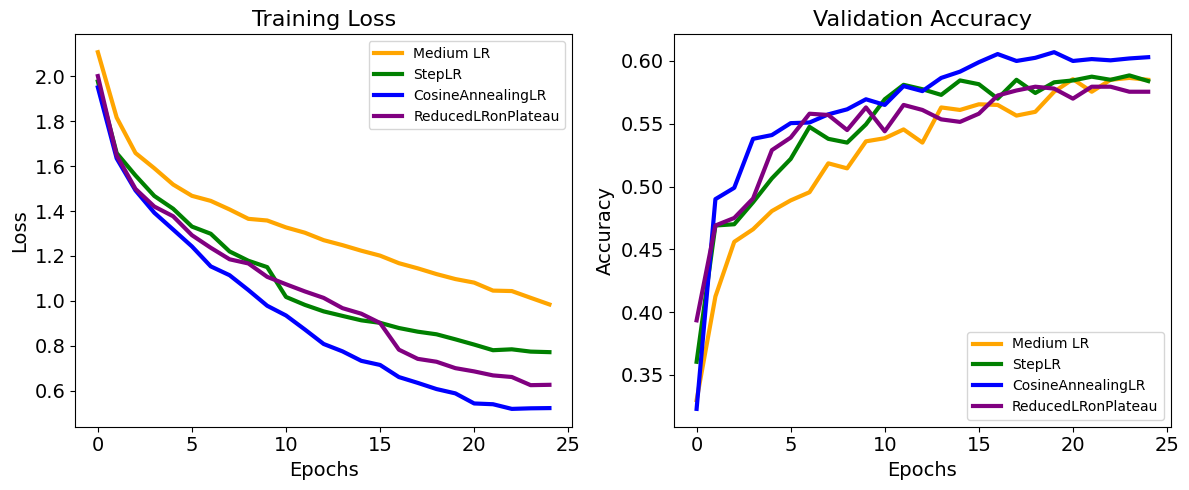

In [17]:
labels = ['Medium LR', 'StepLR', 'CosineAnnealingLR', 'ReducedLRonPlateau']
colors = ['orange', 'green', 'blue', 'purple']

training_curves_new = [history_constant, history_LR, history_cosine, history_plateau]

helper_utils.plot_learning_curves(colors, labels, training_curves_new)

<br>

Al analizar el validation accuracy, verás que tanto el scheduler `ReduceLROnPlateau` como el `CosineAnnealingLR` producen mejores resultados al observar el último epoch. Ten en cuenta que cada scheduler también tiene hyperparameters ajustables. 

A continuación, se ilustra cómo cambia el learning rate a lo largo de los epochs para cada scheduler. El scheduler `CosineAnnealingLR` reduce el learning rate siguiendo un patrón de decaimiento de coseno (cosine decay), mientras que `ReduceLROnPlateau` lo ajusta dinámicamente basándose en el rendimiento de la validación.

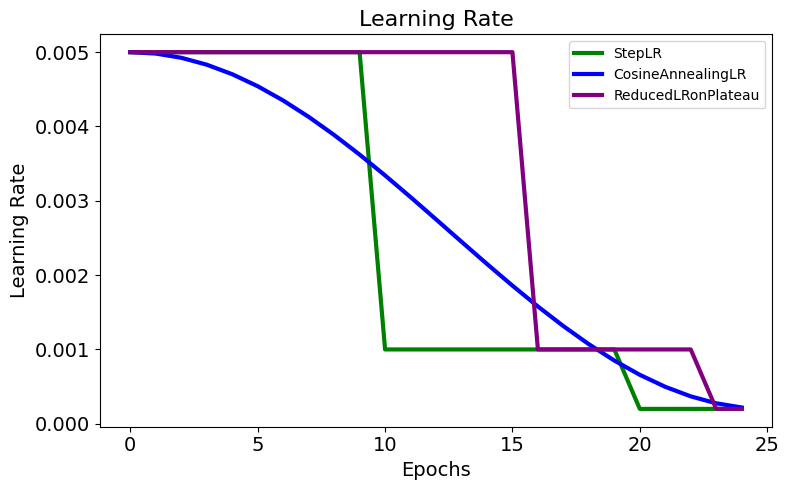

In [18]:
helper_utils.plot_learning_rates_curves(training_curves_new, colors, labels)

<br>

En resumen:

- `StepLR` es efectivo para reducir el learning rate en intervalos fijos de manera escalonada.

- `CosineAnnealingLR` ofrece un decaimiento suave (smooth decay) sin cambios bruscos, lo cual es beneficioso para el fine-tuning del modelo a medida que el entrenamiento concluye. Es particularmente ventajoso para sesiones de entrenamiento largas donde los ajustes graduales pueden mejorar la convergencia.

- `ReduceLROnPlateau` es útil cuando el rendimiento de la validación se estanca (plateaus), ya que ajusta el learning rate basándose en métricas de validación, mejorando potencialmente la generalización. Es reactivo al rendimiento del modelo, permitiendo ajustes dinámicos basados en la dinámica del entrenamiento.

# Conclusion

¡Felicitaciones por completar esta exploración profunda de los learning rate schedulers de PyTorch! En este notebook, examinaste cómo el ajuste dinámico del learning rate puede mejorar la eficiencia del entrenamiento, acelerar la convergencia y mejorar la generalización en comparación con un learning rate constante. Al utilizar schedulers y visualizar sus efectos en las métricas de entrenamiento y validación, observaste cómo contribuyen a un mejor rendimiento del modelo. Además, ganaste experiencia valiosa en el ajuste de los hyperparameters de los schedulers para adaptarse a diversos escenarios de entrenamiento.